In [1]:
from poke_env.player import Gen8EnvSinglePlayer
from poke_env.data import GenData
from gymnasium.spaces import Space, Box, Dict
import numpy as np

class SimpleRLPlayer(Gen8EnvSinglePlayer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def calc_reward(self, last_battle, current_battle) -> float:
        """
        Calculate reward based on battle state changes
        """
        return self.reward_computing_helper(
            current_battle, 
            fainted_value=2.0, 
            hp_value=1.0, 
            victory_value=30.0
        )

    '''def calc_reward(self, last_battle, current_battle) -> float:
        """
        Calculate reward based on battle state changes
        """
        if current_battle.won:
            return 30.0
        
        # Get number of fainted Pokemon for both sides
        n_fainted_mon = len([mon for mon in current_battle.team.values() if mon.fainted])
        n_fainted_opp = len([mon for mon in current_battle.opponent_team.values() if mon.fainted])
        
        # Calculate HP percentages
        total_hp_fraction = sum(mon.current_hp_fraction for mon in current_battle.team.values() if not mon.fainted)
        total_opp_hp_fraction = sum(mon.current_hp_fraction for mon in current_battle.opponent_team.values() if not mon.fainted)
        
        return (n_fainted_opp - n_fainted_mon) * 5.0 + (total_hp_fraction - total_opp_hp_fraction) * 2.0'''
    
    

    def embed_battle(self, battle):
        """
        Create observation embedding from battle state
        """
        # -1 indicates that the move does not have a base power or is not available
        moves_base_power = -np.ones(4)      # Default to -1 for unavailable moves
        moves_dmg_multiplier = np.ones(4)   # Default to neutral effectiveness (1x)
        
        # Get the type chart for Generation 8
        type_chart = GenData.from_gen(8).type_chart
        
        
        # Process each available move
        for i, move in enumerate(battle.available_moves):
            # Normalize move base power to [0,1] range by dividing by 100
            moves_base_power[i] = (move.base_power / 100)
            
            
            # Calculate type effectiveness
            if move.type and battle.opponent_active_pokemon:
                try:
                    moves_dmg_multiplier[i] = move.type.damage_multiplier(
                        battle.opponent_active_pokemon.type_1,
                        battle.opponent_active_pokemon.type_2,
                        type_chart=type_chart
                        
                        
                    )
                except Exception as e:
                    print(f"Error in damage multiplier: {e}")
                    #moves_dmg_multiplier[i] = 1
        
        # Count fainted Pokemon
        fainted_mon_team = len([mon for mon in battle.team.values() if mon.fainted]) / 6
        fainted_mon_opp = len([mon for mon in battle.opponent_team.values() if mon.fainted]) / 6

        # Final vector with 10 components
        final_vector = np.concatenate([
            moves_base_power,           # 4 values
            moves_dmg_multiplier,       # 4 values
            [fainted_mon_team, fainted_mon_opp],  # 2 values
        ])
        
        return np.float32(final_vector)

    def describe_embedding(self) -> Space:
        """
        Describe the observation space
        """
        # Lower bounds for each component
        low = [
            -1, -1, -1, -1,  # Move base power: -1 means move not available
            0, 0, 0, 0,      # Move damage multiplier: 0x to 4x effectiveness
            0, 0             # Fainted Pokemon ratios: 0 to 1 (0% to 100%)
        ]
        
        # Upper bounds for each component
        high = [
            3, 3, 3, 3,     # Move base power: normalized to 0-3 range
            4, 4, 4, 4,     # Move damage multiplier: up to 4x effectiveness
            1, 1            # Fainted Pokemon ratios: 0 to 1 (0% to 100%)
        ]
                
        return Box(
            np.array(low, dtype=np.float32),
            np.array(high, dtype=np.float32),
            dtype=np.float32
        )

    '''def action_to_move(self, action: int, battle) -> str:
        """
        Converts actions to move orders.
        
        The conversion is done as follows:
        action = -1: Forfeit
        0 <= action < 4: Regular moves
        4 <= action < 8: Z-moves (not used in Gen8)
        8 <= action < 12: Mega Evolution (not used in Gen8)
        12 <= action < 16: Dynamax moves
        16 <= action < 22: Switches
        """
        if action == -1:
            return self.choose_random_move(battle)
            
        # Regular moves
        if 0 <= action < 4:
            try:
                return self.create_order(battle.available_moves[action])
            except IndexError:
                return self.choose_random_move(battle)
                
        # Dynamax moves
        elif 12 <= action < 16 and battle.can_dynamax:
            try:
                move = battle.available_moves[action - 12]
                return self.create_order(move, dynamax=True)
            except IndexError:
                return self.choose_random_move(battle)
                
        # Switches
        elif 16 <= action < 22:
            try:
                switches = list(battle.available_switches)
                if switches:
                    return self.create_order(switches[action - 16])
            except IndexError:
                pass
                
        # If no legal action was found, choose a random move
        return self.choose_random_move(battle)'''

In [2]:
from poke_env.player.random_player import RandomPlayer
# Create the environment
opponent = RandomPlayer(battle_format="gen8randombattle")
env = SimpleRLPlayer(
    battle_format="gen8randombattle",
    opponent=opponent,
    start_challenging=True
)

try:
    # Training loop
    n_battles = 1  # Number of battles to run
    for _ in range(n_battles):
        done = False
        obs = env.reset()  # Reset for new battle
        
        while not done:    
            # Sample a random action
            action = env.action_space.sample()
            
            # Take step in environment
            obs, reward, done, truncated, info = env.step(action)
            print(f"Observation: {obs}")
            print(f"Action: {action}, Reward: {reward}")
        
        print("Battle finished!")
        
finally:
    # Properly close the environment
    env.close()

Observation: [0.  1.2 0.  1.1 2.  2.  0.5 1.  0.  0. ]
Action: 14, Reward: 0.0
Observation: [0.8  0.75 1.   0.   0.5  0.5  1.   0.   0.   0.  ]
Action: 20, Reward: 0.0
Observation: [0.  1.2 0.  1.1 2.  2.  0.5 1.  0.  0. ]
Action: 21, Reward: -0.1939163498098857
Observation: [0.  1.2 0.  1.1 1.  1.  1.  0.  0.  0. ]
Action: 11, Reward: 0.060836501901140316
Observation: [1.  1.  1.2 1.1 0.  4.  1.  2.  0.  0. ]
Action: 18, Reward: 0.0
Observation: [0.8 0.  0.  0.  1.  1.  1.  1.  0.  0. ]
Action: 4, Reward: -0.28095238095238084
Observation: [0.  1.2 0.  1.1 1.  1.  1.  0.  0.  0. ]
Action: 15, Reward: 0.060836501901140316
Observation: [0.  1.2 0.  1.1 1.  1.  1.  0.  0.  0. ]
Action: 5, Reward: -0.007604562737641984
Observation: [0.8  0.75 1.   0.   1.   1.   1.   1.   0.   0.  ]
Action: 20, Reward: 0.21999999999999997
Observation: [-1.         -1.         -1.         -1.          1.          1.
  1.          1.          0.16666667  0.        ]
Action: 4, Reward: -2.9399999999999995
Obs

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )
        
    def forward(self, x):
        return self.network(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

In [67]:
import time
import traceback
import torch.nn.functional as F
import os

def evaluate_during_training(model, n_eval_battles=50):
    """
    Evaluate the model during training
    """
    
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    
    model.eval()
    opponent = RandomPlayer(battle_format="gen8randombattle")
    env = SimpleRLPlayer(battle_format="gen8randombattle", opponent=opponent, start_challenging=True)
    
    total_rewards = 0
    wins = 0
    
    try:
        for _ in range(n_eval_battles):
            state_tuple = env.reset()
            # Extract just the observation from the reset tuple
            state = state_tuple[0] if isinstance(state_tuple, tuple) else state_tuple
            state = np.array(state, dtype=np.float32)  # Convert to numpy array
            battle_done = False
            battle_reward = 0
            
            while not battle_done:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                    q_values = model(state_tensor)
                    action = q_values.max(1)[1].item()
                
                next_state, reward, done, truncated, info = env.step(action)
                battle_done = done or truncated
                battle_reward += reward
                state = next_state
            
            total_rewards += battle_reward
            if battle_reward > 30:
                wins += 1
    
    finally:
        env.close()
    
    avg_reward = total_rewards / n_eval_battles
    win_rate = wins / n_eval_battles
    model.train()
    return avg_reward, win_rate



def train_agent():
    # Hyperparameters
    BATCH_SIZE = 64
    GAMMA = 0.99
    EPSILON_START = 1.0
    EPSILON_END = 0.05
    EPSILON_DECAY = 0.997
    #LEARNING_RATE = 0.0001
    BUFFER_SIZE = 100000
    MIN_REPLAY_SIZE = 1000
    N_BATTLES = 5000
    TARGET_UPDATE = 10
    
    INITIAL_LR = 0.001
    LR_DECAY = 0.995
    MIN_LR = 0.00001
    
    MODEL_DIR = "saved_models"
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    best_eval_reward = float('-inf')
    best_win_rate = 0
    best_combined_reward = float('-inf')
    EVAL_FREQUENCY = 100    # Evaluate every 100 battles
    N_EVAL_BATTLES = 50     # Number of battles to evaluate
    
    
    # Initialize DQN and target network
    input_size = 10  # Size of your observation space
    output_size = 22  # Size of your action space
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    policy_net = DQN(input_size, output_size).to(device)
    target_net = DQN(input_size, output_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    
    # Use a learning rate scheduler
    optimizer = optim.Adam(policy_net.parameters(), lr=INITIAL_LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',           # We want to maximize evaluation metrics
        factor=0.5,          # Multiply LR by this factor
        patience=3,          # Number of evaluations to wait
        threshold=0.01,      # Minimum change to count as improvement
        min_lr=MIN_LR,
        verbose=True
    )
    
    memory = ReplayBuffer(BUFFER_SIZE)
    epsilon = EPSILON_START
    
    # Create environment
    opponent = RandomPlayer(battle_format="gen8randombattle")
    env = SimpleRLPlayer(battle_format="gen8randombattle", opponent=opponent, start_challenging=True)
    
    # Training metrics
    rewards_history = []
    win_history = []
    epsilon_history = []
    lr_history = []
    eval_rewards_history = []
    eval_winrate_history = []
    eval_combined_history = []
    
    # For tracking average reward
    reward_window = deque(maxlen=100)
    
    
    try:
        for battle in range(N_BATTLES):
            battle_done = False
            state_tuple = env.reset()
            # Extract just the observation from the reset tuple
            state = state_tuple[0] if isinstance(state_tuple, tuple) else state_tuple
            state = np.array(state, dtype=np.float32)  # Convert to numpy array
            total_reward = 0
            
            while not battle_done:
                # Epsilon-greedy action selection
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                        q_values = policy_net(state_tensor)
                        action = q_values.max(1)[1].item()
                
                # Take action and observe result
                next_state, reward, done, truncated, info = env.step(action)
                battle_done = done or truncated
                next_state = np.array(next_state, dtype=np.float32)  # Convert to numpy array
                total_reward += reward
                
                # Store transition in replay buffer
                memory.push(state.copy(), action, reward, next_state.copy(), done)
                state = next_state
                
                # Train if enough samples in buffer
                if len(memory) > MIN_REPLAY_SIZE:
                    batch = memory.sample(BATCH_SIZE)
                    states, actions, rewards, next_states, dones = zip(*batch)
                    
                    states = torch.FloatTensor(states).to(device)
                    actions = torch.LongTensor(actions).to(device)
                    rewards = torch.FloatTensor(rewards).to(device)
                    next_states = torch.FloatTensor(next_states).to(device)
                    dones = torch.FloatTensor(dones).to(device)
                    
                    # Compute Q values
                    current_q_values = policy_net(states).gather(1, actions.unsqueeze(1))
                    # Next Q values using target network for stability
                    with torch.no_grad():
                        next_q_values = target_net(next_states).max(1)[0]
                    target_q_values = rewards + GAMMA * next_q_values
                    
                    # Compute loss and update
                    loss = F.smooth_l1_loss(current_q_values.squeeze(), target_q_values)
                    optimizer.zero_grad()
                    loss.backward()
                    # Gradient clipping to prevent exploding gradients
                    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                    optimizer.step()
            
            # Update target network and epsilon
            if battle % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())
            
            epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
            
            # Update learning rate at the end of each battle
            current_lr = optimizer.param_groups[0]['lr']
            
            print(f"Battle {battle + 1}/{N_BATTLES}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}, Learning Rate: {current_lr:.6f}")
            
            # Store metrics
            rewards_history.append(total_reward)
            win_history.append(1 if total_reward > 30 else 0)
            epsilon_history.append(epsilon)
            lr_history.append(current_lr)
            
                
            # Periodic evaluation and model saving
            if (battle + 1) % EVAL_FREQUENCY == 0:
                avg_eval_reward, win_rate = evaluate_during_training(policy_net, N_EVAL_BATTLES)
                eval_rewards_history.append(avg_eval_reward)
                eval_winrate_history.append(win_rate)
                eval_combined_history.append(avg_eval_reward + win_rate)
                
                # Update learning rate based on evaluation metrics
                scheduler.step(avg_eval_reward + win_rate)  # Could also use avg_eval_reward
                
                
                print(f"\nEvaluation at battle {battle + 1}:")
                print(f"Average Evaluation Reward: {avg_eval_reward:.2f}")
                print(f"Win Rate: {win_rate:.3f}")
                print(f"Combined Reward: {avg_eval_reward + win_rate:.2f}")
                print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
                
                
                # Save latest model
                torch.save({
                    'battle': battle,
                    'model_state_dict': policy_net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'avg_reward': avg_eval_reward,
                    'win_rate': win_rate,
                    'epsilon': epsilon
                }, os.path.join(MODEL_DIR, 'latest_model.pth'))
                
                # Save best model based on evaluation reward
                if avg_eval_reward > best_eval_reward:
                    best_eval_reward = avg_eval_reward
                    torch.save({
                        'battle': battle,
                        'model_state_dict': policy_net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'avg_reward': avg_eval_reward,
                        'win_rate': win_rate,
                        'epsilon': epsilon
                    }, os.path.join(MODEL_DIR, 'best_reward_model.pth'))
                
                # Save best model based on win rate
                if win_rate > best_win_rate:
                    best_win_rate = win_rate
                    torch.save({
                        'battle': battle,
                        'model_state_dict': policy_net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'avg_reward': avg_eval_reward,
                        'win_rate': win_rate,
                        'epsilon': epsilon
                    }, os.path.join(MODEL_DIR, 'best_winrate_model.pth'))
                    
                # Save best model based on combined reward and win rate
                if avg_eval_reward + win_rate > best_combined_reward:
                    best_combined_reward = avg_eval_reward + win_rate
                    torch.save({
                        'battle': battle,
                        'model_state_dict': policy_net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'avg_reward': avg_eval_reward,
                        'win_rate': win_rate,
                        'epsilon': epsilon
                    }, os.path.join(MODEL_DIR, 'best_combined_model.pth'))
                
                print(f"Best Evaluation Reward so far: {best_eval_reward:.2f}")
                print(f"Best Win Rate so far: {best_win_rate:.3f}")
                print(f"Best Evaluation Combined Reward so far: {best_combined_reward:.2f}")
                print("--------------------")
            
    except Exception as e:
        print(f"An error occurred: {e}")
        print(f"Traceback: {traceback.format_exc()}")
            
    finally:
        env.close()
        return policy_net, rewards_history, win_history, epsilon_history, eval_rewards_history, eval_winrate_history, eval_combined_history
    
# Function to load a saved model
def load_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DQN(input_size=10, output_size=22).to(device)
    
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Loaded model from battle {checkpoint['battle']}")
    print(f"Saved metrics - Reward: {checkpoint['avg_reward']:.2f}, Win Rate: {checkpoint['win_rate']:.3f}")
    
    return model


Battle 1/5000, Total Reward: -32.13, Epsilon: 0.997, Learning Rate: 0.001000
Battle 2/5000, Total Reward: -37.8, Epsilon: 0.994, Learning Rate: 0.001000
Battle 3/5000, Total Reward: -33.0, Epsilon: 0.991, Learning Rate: 0.001000
Battle 4/5000, Total Reward: 35.76371308016878, Epsilon: 0.988, Learning Rate: 0.001000
Battle 5/5000, Total Reward: 36.96120523487925, Epsilon: 0.985, Learning Rate: 0.001000
Battle 6/5000, Total Reward: 35.00350877192982, Epsilon: 0.982, Learning Rate: 0.001000
Battle 7/5000, Total Reward: -32.17, Epsilon: 0.979, Learning Rate: 0.001000
Battle 8/5000, Total Reward: -32.07, Epsilon: 0.976, Learning Rate: 0.001000
Battle 9/5000, Total Reward: -35.21000000000001, Epsilon: 0.973, Learning Rate: 0.001000
Battle 10/5000, Total Reward: -35.28, Epsilon: 0.970, Learning Rate: 0.001000
Battle 11/5000, Total Reward: 32.11711711711712, Epsilon: 0.967, Learning Rate: 0.001000
Battle 12/5000, Total Reward: -34.87, Epsilon: 0.965, Learning Rate: 0.001000
Battle 13/5000, Tot

ValueError: num must be an integer with 1 <= num <= 3, not 4

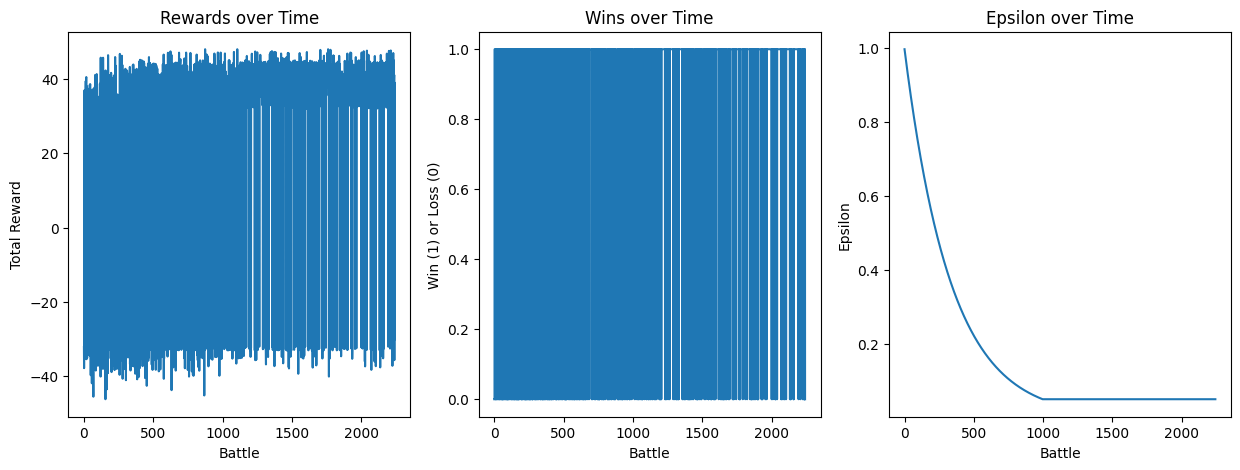

In [61]:
# Train the agent
trained_model, rewards_history, win_history, epsilon_history, eval_rewards_history, eval_winrate_history, eval_combined_history = train_agent()

# Plot training metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rewards_history)
plt.title('Rewards over Time')
plt.xlabel('Battle')
plt.ylabel('Total Reward')

plt.subplot(1, 3, 2)
plt.plot(win_history)
plt.title('Wins over Time')
plt.xlabel('Battle')
plt.ylabel('Win (1) or Loss (0)')

plt.subplot(1, 3, 3)
plt.plot(epsilon_history)
plt.title('Epsilon over Time')
plt.xlabel('Battle')
plt.ylabel('Epsilon')

plt.subplot(1, 3, 4)
plt.plot(eval_rewards_history)
plt.title('Evaluation Reward over Time')
plt.xlabel('Evaluation (every 100 battles)')
plt.ylabel('Evaluation Reward')

plt.subplot(1, 3, 5)
plt.plot([x * 100 for x in eval_winrate_history])
plt.title('Evaluation Win Rate')
plt.xlabel('Evaluation (every 100 battles)')
plt.ylabel('Win Rate (%)')

plt.subplot(1, 3, 6)
plt.plot(eval_combined_history)
plt.title('Evaluation Combined Reward over Time')
plt.xlabel('Evaluation (every 100 battles)')
plt.ylabel('Evaluation Combined Reward')

plt.tight_layout()
plt.show()

In [69]:


def evaluate_agent(trained_model, n_battles=100, use_model=True):
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trained_model = trained_model.to(device)
    
    # Set the model to evaluation mode
    trained_model.eval()
    
    # Create a new environment for evaluation
    opponent = RandomPlayer(battle_format="gen8randombattle")
    env = SimpleRLPlayer(battle_format="gen8randombattle", opponent=opponent, start_challenging=True)
    
    total_rewards = 0
    wins = 0
    
    try:
        for battle in range(n_battles):
            state_tuple = env.reset()
            # Extract just the observation from the reset tuple
            state = state_tuple[0] if isinstance(state_tuple, tuple) else state_tuple
            state = np.array(state, dtype=np.float32)  # Convert to numpy array
            done = False
            battle_reward = 0
            
            while not done:
                if use_model == True:
                    with torch.no_grad():
                        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                        q_values = trained_model(state_tensor)
                        action = q_values.max(1)[1].item()
                else:
                    action = env.action_space.sample()
                
                next_state, reward, done, truncated, info = env.step(action)
                battle_reward += reward
                state = next_state
            
            total_rewards += battle_reward
            if battle_reward > 30:  # Assuming victory_value=30.0 in your reward function
                wins += 1
            
            print(f"Battle {battle + 1}/{n_battles}, Reward: {battle_reward:.2f}")
        
        win_rate = (wins / n_battles) * 100
        avg_reward = total_rewards / n_battles
        print(f"\nEvaluation Results:")
        print(f"Average Reward: {avg_reward:.2f}")
        print(f"Win Rate: {win_rate:.3f}")
        print(f"Wins: {wins}/{n_battles}")
    
    finally:
        env.close()

model = load_model('C:/Users/JJ/OneDrive/Documents/CS224P HW/Project/saved_models/best_combined_model.pth')
# Test with fewer battles first
evaluate_agent(model, n_battles=50, use_model=True)

Loaded model from battle 1599
Saved metrics - Reward: 35.23, Win Rate: 0.960
Battle 1/50, Reward: 40.63
Battle 2/50, Reward: 40.99
Battle 3/50, Reward: 47.48
Battle 4/50, Reward: -35.44
Battle 5/50, Reward: 47.54
Battle 6/50, Reward: 32.41
Battle 7/50, Reward: 41.57
Battle 8/50, Reward: 38.32
Battle 9/50, Reward: 41.06
Battle 10/50, Reward: 44.26
Battle 11/50, Reward: 41.59
Battle 12/50, Reward: 32.78
Battle 13/50, Reward: -32.57
Battle 14/50, Reward: -32.09
Battle 15/50, Reward: 38.38
Battle 16/50, Reward: 35.74
Battle 17/50, Reward: 42.00
Battle 18/50, Reward: 44.87
Battle 19/50, Reward: 41.53
Battle 20/50, Reward: 44.34
Battle 21/50, Reward: 38.33
Battle 22/50, Reward: 39.00
Battle 23/50, Reward: 41.24
Battle 24/50, Reward: 33.00
Battle 25/50, Reward: 38.91
Battle 26/50, Reward: 41.85
Battle 27/50, Reward: 35.49
Battle 28/50, Reward: 36.00
Battle 29/50, Reward: 36.00
Battle 30/50, Reward: 39.00
Battle 31/50, Reward: 39.00
Battle 32/50, Reward: 41.81
Battle 33/50, Reward: 36.00
Battl

In [70]:
# Test with fewer battles first
evaluate_agent(trained_model, n_battles=50, use_model=False)

Battle 1/50, Reward: 35.93
Battle 2/50, Reward: -37.23
Battle 3/50, Reward: 42.08
Battle 4/50, Reward: -38.03
Battle 5/50, Reward: -33.00
Battle 6/50, Reward: 32.04
Battle 7/50, Reward: 32.50
Battle 8/50, Reward: -38.13
Battle 9/50, Reward: 39.56
Battle 10/50, Reward: 35.91
Battle 11/50, Reward: 38.32
Battle 12/50, Reward: -37.73
Battle 13/50, Reward: -38.78
Battle 14/50, Reward: 34.57
Battle 15/50, Reward: -34.70
Battle 16/50, Reward: -42.62
Battle 17/50, Reward: -32.42
Battle 18/50, Reward: 34.60
Battle 19/50, Reward: -33.00
Battle 20/50, Reward: -35.83
Battle 21/50, Reward: -32.58
Battle 22/50, Reward: -32.67
Battle 23/50, Reward: -37.84
Battle 24/50, Reward: -32.99
Battle 25/50, Reward: 34.64
Battle 26/50, Reward: 34.82
Battle 27/50, Reward: -42.93
Battle 28/50, Reward: -32.15
Battle 29/50, Reward: -32.44
Battle 30/50, Reward: -32.24
Battle 31/50, Reward: 43.43
Battle 32/50, Reward: -43.70
Battle 33/50, Reward: -34.97
Battle 34/50, Reward: -35.04
Battle 35/50, Reward: -33.00
Battle